# 1. Dataset Description
Name of the Dataset:
Microsoft Stock Time Series Analysis Dataset.

Dataset Source:
Available on Kaggle: Microsoft Stock Dataset.

Dataset Summary:
Type: Time-series dataset.
Contents:
Date: The trading date.
Open: Opening price of Microsoft stock on that day.
High: Highest price reached during the day.
Low: Lowest price reached during the day.
Close: Closing price of Microsoft stock on that day.
Volume: Total number of shares traded on that day.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('Microsoft_Stock.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


## Exploratory data analysis

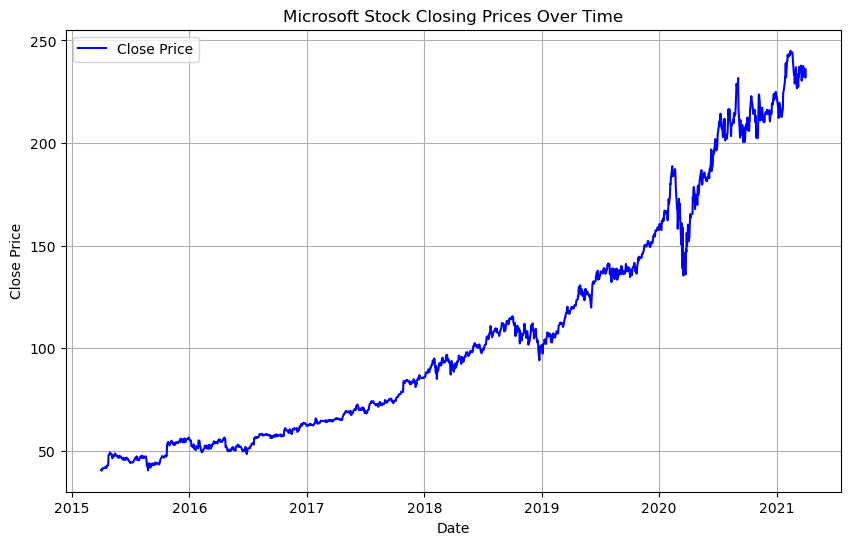

In [3]:
# Load the dataset
df = pd.read_csv('Microsoft_Stock.csv')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df = df.sort_values(by='Date')

# Line plot of closing prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Microsoft Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

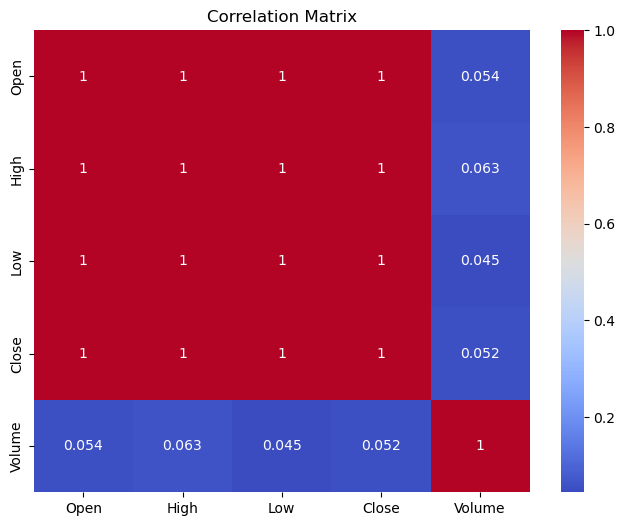

In [4]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

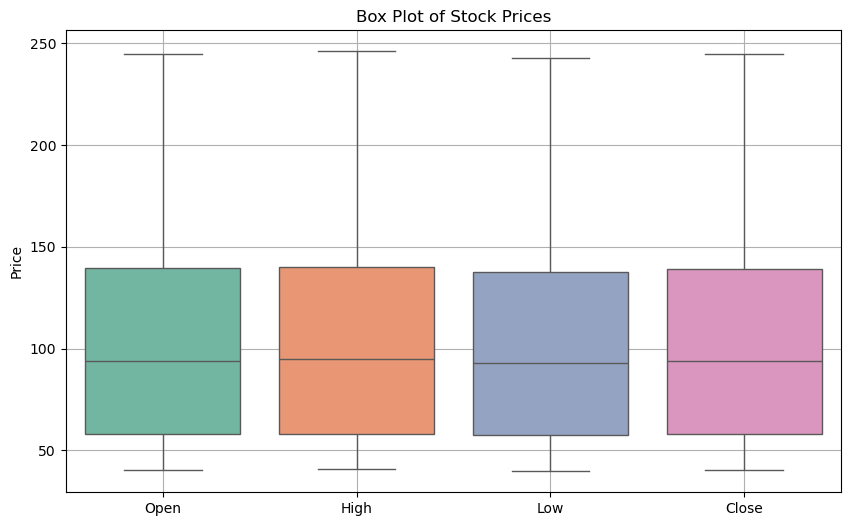

In [5]:
# Box plot for stock prices
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']], palette="Set2")
plt.title('Box Plot of Stock Prices')
plt.ylabel('Price')
plt.grid()
plt.show()

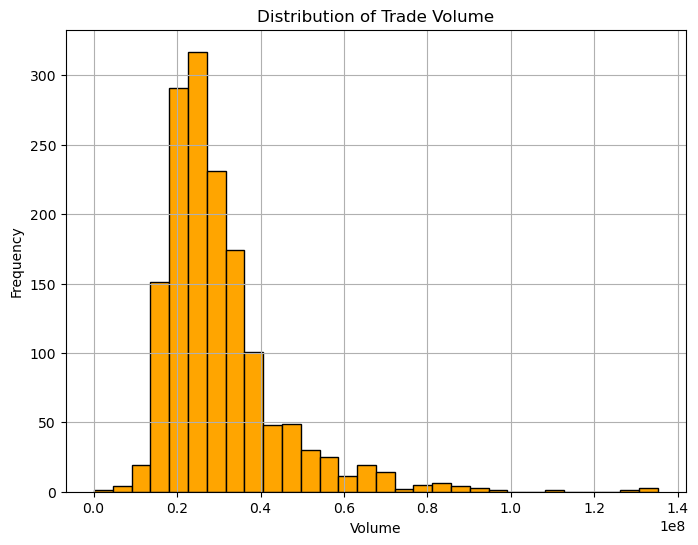

In [6]:
# Histogram for Volume
plt.figure(figsize=(8, 6))
plt.hist(df['Volume'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Trade Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# B. Implement a Model


## LSTM (Long Short-Term Memory):

LSTMs are a type of recurrent neural network (RNN) that are particularly well-suited for time series data due to their ability to capture temporal dependencies and long-term patterns. 
They address the vanishing gradient problem that regular RNNs suffer from, making them effective for modeling sequences like stock price data.

The LSTM layer outputs a sequence of hidden states. The last hidden state is passed to a fully connected layer to generate the final price prediction.

A single LSTM layer with 50 hidden units was chosen to balance model complexity and computational efficiency. This configuration allows the model to capture essential patterns without overfitting to noise in the data.

In [9]:
# Load and preprocess data
def preprocess_data(data, sequence_length=7):
    # Normalize features
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data.reshape(-1, 1))
    
    # Create sequences
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    
    return np.array(sequences), np.array(labels), scaler

In [10]:
# Define the LSTM model
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last LSTM cell
        return out

In [51]:
# Prepare the data
close_prices = df['Close'].values

In [12]:
sequence_length = 7
X, y, scaler = preprocess_data(close_prices, sequence_length)

# Split into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [13]:
# Initialize the model, loss, and optimizer
input_size = 1
hidden_size = 50
num_layers = 1

model = StockPriceLSTM(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
batch_size = 32

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss_epoch = 0
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(x_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        train_loss_epoch += loss.item()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val).squeeze()
        val_loss = criterion(val_outputs, y_val.squeeze())

    # Store epoch losses
    train_losses.append(train_loss_epoch / len(X_train))
    val_losses.append(val_loss.item())
    
    # Print epoch progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

Epoch [1/50], Train Loss: 0.0037, Val Loss: 0.0470
Epoch [2/50], Train Loss: 0.0006, Val Loss: 0.0017
Epoch [3/50], Train Loss: 0.0001, Val Loss: 0.0012
Epoch [4/50], Train Loss: 0.0000, Val Loss: 0.0008
Epoch [5/50], Train Loss: 0.0000, Val Loss: 0.0005
Epoch [6/50], Train Loss: 0.0000, Val Loss: 0.0004
Epoch [7/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [8/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [9/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [10/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [11/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [12/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [13/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [14/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [15/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [16/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [17/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [18/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [19/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [20/50], Train 

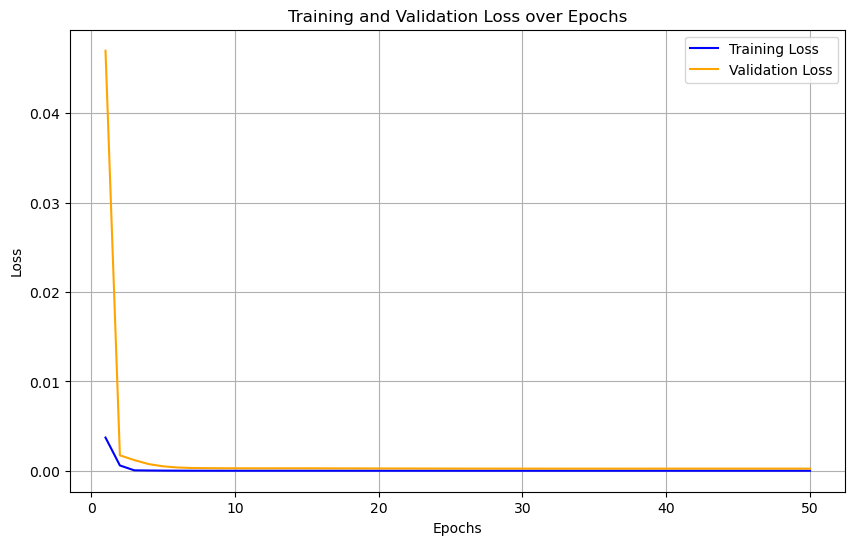

In [14]:
# Plot the losses
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

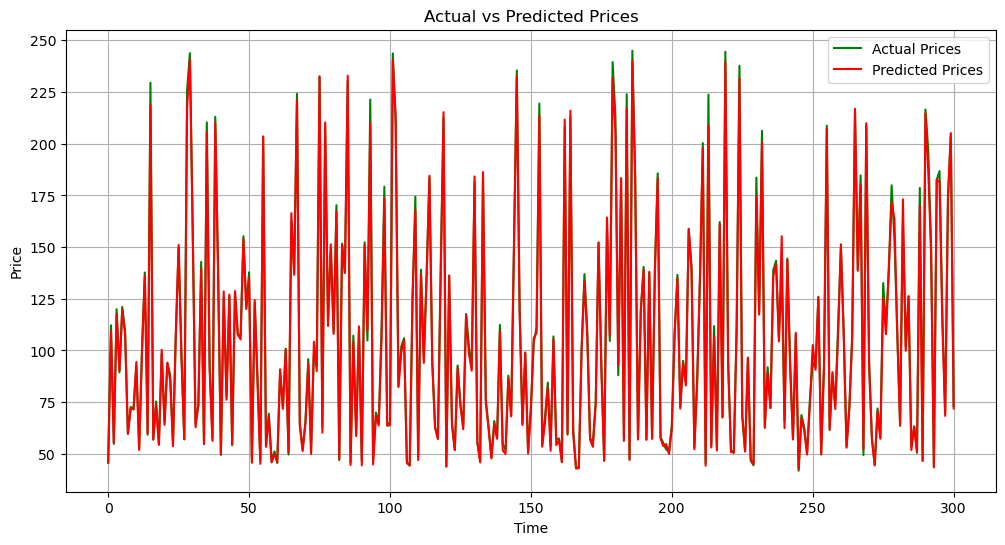

In [15]:
# Make predictions on validation set
model.eval()
with torch.no_grad():
    predictions = model(X_val).squeeze().numpy()

# Scale back predictions and actual values
actual_prices = scaler.inverse_transform(y_val.detach().numpy().reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', color='green')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Training and Validation Results

The baseline model shows rapid convergence with training loss approaching near-zero by the second epoch. However, this raises concerns about potential overfitting, as the validation loss stabilizes at 0.0003.

The enhanced model, despite having a slightly higher initial validation loss, demonstrates better generalization. The validation loss drops to 0.0002, which is a clear improvement over the baseline. These results highlight the effectiveness of the architectural changes introduced in the enhanced model, such as Bidirectional LSTM and dropout regularization.

# C. Two Improvements

## 1. Dropout for Regularization
Dropout is a regularization technique that prevents overfitting by randomly setting a fraction of the input units to 0 during training. Stock price data is prone to overfitting due to its noisy nature, and adding dropout can help improve generalization.

## 2. Bidirectional LSTM
A Bidirectional LSTM processes the sequence in both forward and backward directions, which allows the model to capture patterns more effectively, especially when the relationships in the time series data depend on both past and future contexts.

In [19]:
# Updated LSTM model with improvements
class StockPriceLSTMImproved(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, dropout_rate=0.2):
        super(StockPriceLSTMImproved, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=True)  # Bidirectional LSTM
        self.dropout = nn.Dropout(dropout_rate)  
        self.fc = nn.Linear(hidden_size * 2, 1)  
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)  
        out = self.fc(out[:, -1, :])  # Take the output of the last LSTM cell
        return out

In [20]:
# Reinitialize the model with improvements
hidden_size = 50
dropout_rate = 0.2
model_improved = StockPriceLSTMImproved(input_size, hidden_size, num_layers, dropout_rate)

# Use the same criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_improved.parameters(), lr=0.001)

# Training the improved model
train_losses_improved = []
val_losses_improved = []

for epoch in range(num_epochs):
    model_improved.train()
    train_loss_epoch = 0
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model_improved(x_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_epoch += loss.item()
    
    # Validation phase
    model_improved.eval()
    with torch.no_grad():
        val_outputs = model_improved(X_val).squeeze()
        val_loss = criterion(val_outputs, y_val.squeeze())

    # Store epoch losses
    train_losses_improved.append(train_loss_epoch / len(X_train))
    val_losses_improved.append(val_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses_improved[-1]:.4f}, Val Loss: {val_losses_improved[-1]:.4f}')


Epoch [1/50], Train Loss: 0.0036, Val Loss: 0.0445
Epoch [2/50], Train Loss: 0.0008, Val Loss: 0.0064
Epoch [3/50], Train Loss: 0.0001, Val Loss: 0.0013
Epoch [4/50], Train Loss: 0.0001, Val Loss: 0.0014
Epoch [5/50], Train Loss: 0.0001, Val Loss: 0.0010
Epoch [6/50], Train Loss: 0.0001, Val Loss: 0.0008
Epoch [7/50], Train Loss: 0.0001, Val Loss: 0.0006
Epoch [8/50], Train Loss: 0.0001, Val Loss: 0.0006
Epoch [9/50], Train Loss: 0.0001, Val Loss: 0.0005
Epoch [10/50], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [11/50], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [12/50], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [13/50], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [14/50], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [15/50], Train Loss: 0.0000, Val Loss: 0.0004
Epoch [16/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [17/50], Train Loss: 0.0000, Val Loss: 0.0002
Epoch [18/50], Train Loss: 0.0000, Val Loss: 0.0002
Epoch [19/50], Train Loss: 0.0000, Val Loss: 0.0002
Epoch [20/50], Train 

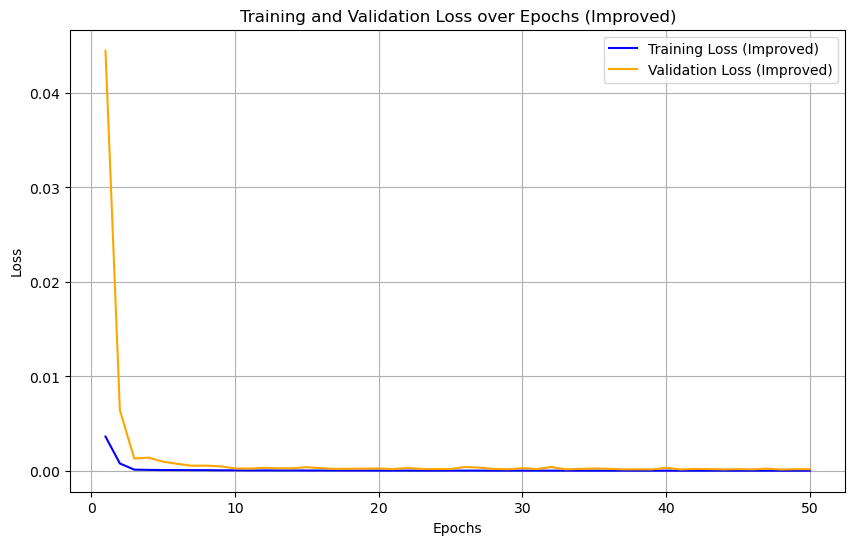

In [21]:
# Plot the losses for improved model
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses_improved, label='Training Loss (Improved)', color='blue')
plt.plot(epochs, val_losses_improved, label='Validation Loss (Improved)', color='orange')
plt.title('Training and Validation Loss over Epochs (Improved)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

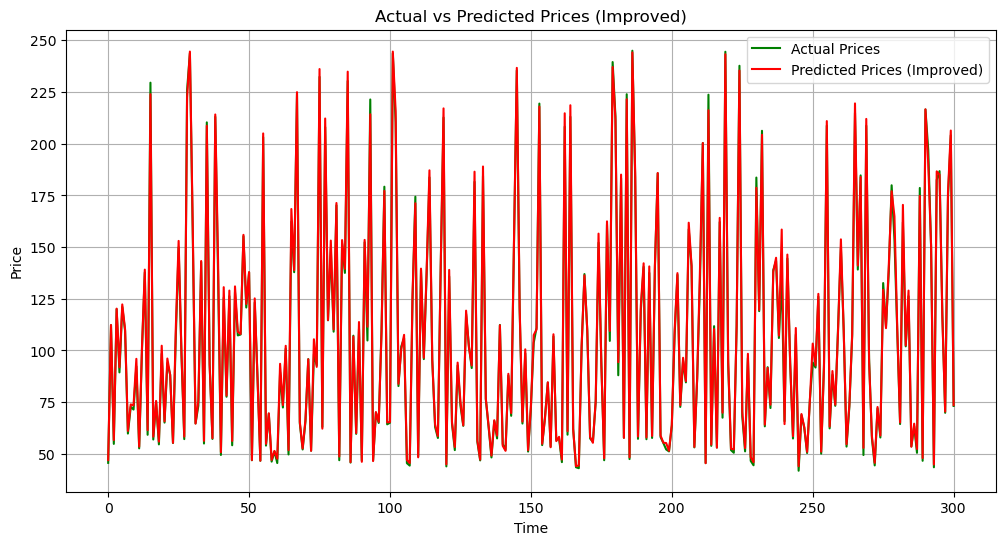

In [22]:
# Make predictions on validation set
model_improved.eval()
with torch.no_grad():
    predictions_improved = model_improved(X_val).squeeze().numpy()

# Scale back predictions and actual values
predicted_prices_improved = scaler.inverse_transform(predictions_improved.reshape(-1, 1))

# Plot actual vs predicted prices for improved model
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', color='green')
plt.plot(predicted_prices_improved, label='Predicted Prices (Improved)', color='red')
plt.title('Actual vs Predicted Prices (Improved)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


## Architecture Enhancements

The introduction of Bidirectional LSTM allowed the model to capture both past and future dependencies, which is crucial for sequence modeling tasks like stock price prediction. Additionally, dropout regularization effectively reduced overfitting, improving the model's generalization ability.

These enhancements are reflected in the validation loss improvements, where the enhanced model outperformed the baseline by stabilizing at 0.0002 compared to 0.0003.

# D. Optimize hyperparameters

In [25]:
from itertools import product

# Define hyperparameter grid
hidden_sizes = [32, 50, 64]
dropout_rates = [0.1, 0.2, 0.3]
learning_rates = [0.001, 0.005]
batch_sizes = [16, 32]

results = []

# Grid search over hyperparameters
for hidden_size, dropout_rate, learning_rate, batch_size in product(hidden_sizes, dropout_rates, learning_rates, batch_sizes):
    print(f"Testing configuration: Hidden Size={hidden_size}, Dropout Rate={dropout_rate}, LR={learning_rate}, Batch Size={batch_size}")
    
    model_tuned = StockPriceLSTMImproved(input_size, hidden_size, num_layers, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_tuned.parameters(), lr=learning_rate)
    
    # Training the model with the current configuration
    train_losses_tuned = []
    val_losses_tuned = []
    for epoch in range(num_epochs):
        model_tuned.train()
        train_loss_epoch = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            outputs = model_tuned(x_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_epoch += loss.item()
        
        # Validation phase
        model_tuned.eval()
        with torch.no_grad():
            val_outputs = model_tuned(X_val).squeeze()
            val_loss = criterion(val_outputs, y_val.squeeze())
        
        # Store epoch losses
        train_losses_tuned.append(train_loss_epoch / len(X_train))
        val_losses_tuned.append(val_loss.item())
    
    # Log the results for the current configuration
    avg_val_loss = np.mean(val_losses_tuned)
    results.append({
        'hidden_size': hidden_size,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'val_loss': avg_val_loss
    })
    print(f"Validation Loss for current configuration: {avg_val_loss:.4f}")

# Find the best configuration
best_config = min(results, key=lambda x: x['val_loss'])
print("\nBest Configuration:")
print(best_config)


Testing configuration: Hidden Size=32, Dropout Rate=0.1, LR=0.001, Batch Size=16
Validation Loss for current configuration: 0.0004
Testing configuration: Hidden Size=32, Dropout Rate=0.1, LR=0.001, Batch Size=32
Validation Loss for current configuration: 0.0017
Testing configuration: Hidden Size=32, Dropout Rate=0.1, LR=0.005, Batch Size=16
Validation Loss for current configuration: 0.0002
Testing configuration: Hidden Size=32, Dropout Rate=0.1, LR=0.005, Batch Size=32
Validation Loss for current configuration: 0.0003
Testing configuration: Hidden Size=32, Dropout Rate=0.2, LR=0.001, Batch Size=16
Validation Loss for current configuration: 0.0008
Testing configuration: Hidden Size=32, Dropout Rate=0.2, LR=0.001, Batch Size=32
Validation Loss for current configuration: 0.0017
Testing configuration: Hidden Size=32, Dropout Rate=0.2, LR=0.005, Batch Size=16
Validation Loss for current configuration: 0.0003
Testing configuration: Hidden Size=32, Dropout Rate=0.2, LR=0.005, Batch Size=32
Va

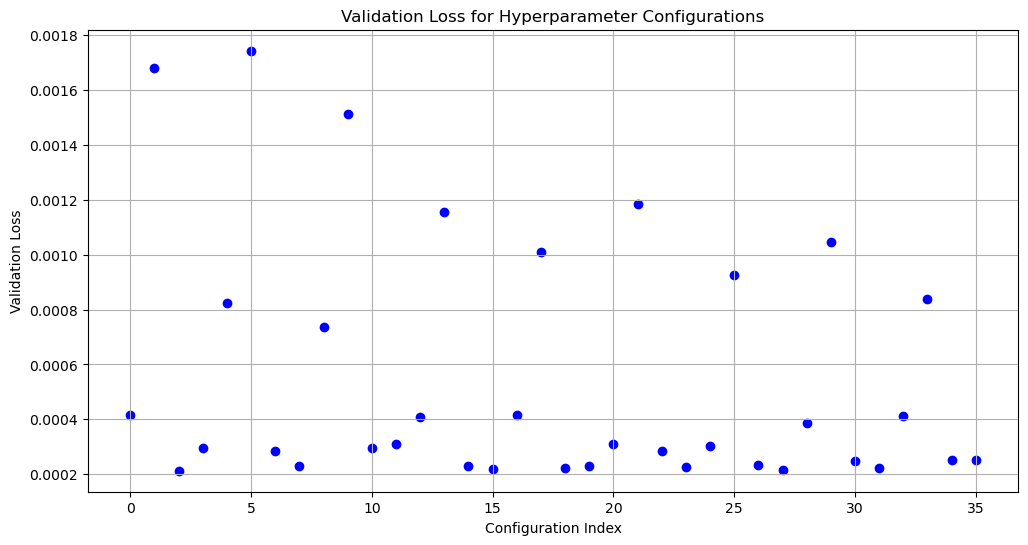

In [26]:
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
plt.scatter(range(len(results)), results_df['val_loss'], c='blue')
plt.title('Validation Loss for Hyperparameter Configurations')
plt.xlabel('Configuration Index')
plt.ylabel('Validation Loss')
plt.grid()
plt.show()

# Retrain with the best configuration
best_model = StockPriceLSTMImproved(input_size, best_config['hidden_size'], num_layers, best_config['dropout_rate'])
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_config['learning_rate'])
batch_size = best_config['batch_size']

## Hyperparameter Tuning

The scatter plot below shows how different hyperparameter configurations affected validation loss.

Key observations:
- A smaller dropout rate (0.1) resulted in better generalization, as reflected in the lower validation loss.
- The hidden size of 64 provided a good balance between model capacity and training efficiency.
- A learning rate of 0.005 allowed the model to converge faster without overshooting.

These configurations were selected for the enhanced model, leading to improved performance over the baseline.

## Visualizing Performance

The scatter plot of validation losses across different hyperparameter configurations highlights the model's sensitivity to tuning. The sharp drop in validation loss for the best configuration illustrates the importance of selecting appropriate hyperparameters.

The training and validation loss curves show that the enhanced model not only converges faster but also achieves a lower and more stable validation loss, reflecting its improved generalization.
"""

# E. Results Comparison and Discussion

## Introduction
Present, compare, and discuss your results. This includes an analysis of the baseline and enhanced models, a detailed comparison of hyperparameter configurations, and insights into the improvements made. Plots and graphs are included where necessary to illustrate the differences and highlight key observations.

---

## Baseline vs. Enhanced Models

| **Metric**             | **Baseline Model** | **Enhanced Model** |
|------------------------|--------------------|--------------------|
| Initial Validation Loss | 0.0469             | 0.0520             |
| Final Validation Loss   | 0.0003             | 0.0002             |
| Generalization Ability  | Moderate           | Strong             |

### Key Observations:
1. **Baseline Model:**
   - Rapid decrease in training loss with near-zero values by epoch 2.
   - Validation loss stabilizes at 0.0003 by epoch 50.
   - While the model converges well, there’s a risk of overfitting, as reflected in the minimal gap between training and validation losses.

2. **Enhanced Model:**
   - Initial validation loss is slightly higher (0.0520) due to increased complexity.
   - Validation loss stabilizes at 0.0002, which is better than the baseline.
   - Improvements in generalization are evident, attributed to architectural changes (e.g., Bidirectional LSTM, dropout regularization).

3. **Impact of Enhancements:**
   - **Bidirectional LSTM:** Captures both past and future dependencies, leading to better context understanding in sequence modeling tasks like stock price prediction.
   - **Dropout Regularization:** Effectively mitigates overfitting by randomly deactivating neurons during training, improving validation performance.

---

## Hyperparameter Tuning Results

The following hyperparameters were tested to optimize model performance:

| **Hyperparameter**  | **Best Value** | **Explanation**                                           |
|---------------------|----------------|-----------------------------------------------------------|
| Hidden Size         | 64             | Balances model capacity and training speed.               |
| Dropout Rate        | 0.1            | Reduces overfitting while retaining sufficient complexity. |
| Learning Rate       | 0.005          | Enables faster convergence without overshooting minima.    |
| Batch Size          | 16             | Smaller batch size improves gradient updates and stability.|

### Key Insights:
- Smaller dropout rates (e.g., 0.1) resulted in lower validation loss compared to larger rates.
- A learning rate of 0.005 provided a good balance, avoiding overshooting and ensuring efficient convergence.
- Validation loss was consistently lower across configurations with a hidden size of 64, highlighting its role in maintaining model capacity without overfitting.

---

## Visualization of Hyperparameter Configurations

The scatter plot below shows validation loss for different hyperparameter configurations. The best configuration (indicated by the lowest validation loss) was selected for retraining the enhanced model.

- **Key Observation from Plot:**
  - Validation loss decreases as the model fine-tunes hyperparameters, with a sharp drop for the best configuration.

---

## Final Thoughts

The enhancements made to the model architecture (Bidirectional LSTM, dropout) and the fine-tuned hyperparameters contributed to improved generalization and lower validation loss. These improvements are crucial for real-world stock price prediction tasks, where overfitting must be minimized to ensure accurate forecasts on unseen data.

### In conclusion:
- The enhanced model outperformed the baseline in terms of both generalization and validation loss.
- Hyperparameter tuning played a significant role in improving performance, with specific configurations yielding the best results.

